In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2


from model.unet.unet_model import UNet
from model.segnet.segnet_model import SegNet
#from model.segnet.segnet2 import SegNet

from utils.dice_score import dice_loss
from utils.data_load import KittiDataset

In [2]:
Val_Percent = 0.4
Scale_Percent = 0.1
Batch_Size = 4
learning_rate = 0.001
Pin_Memory = False
epochs = 1
#Image_Size = [375, 1242]
#Image_Size = [384, 1216]
Image_Size = [384, 1242]
Gradient_Clipping = 1.0


#Num_Class = 34
Num_Class = 31
Num_Channel = 3
amp = False

Img_Path =  'data/training/image_2'
Mask_Path = 'data/training/semantic'

#Img_Path =  'data/feature'
#Mask_Path = 'data/target'



save_checkpoint = True
checkpoint_dir = '../trained'
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)
dir_checkpoint = Path(checkpoint_dir)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
train_transform = A.Compose(
    [
        #A.SmallestMaxSize(max_size=160),
        A.Resize(height=384, width=1242),  # 원하는 크기로 조절합니다.
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=384, width=1242),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        #ToTensorV2(),
        
    ], is_check_shapes=False
)

In [6]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
#datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent, train_transform)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 769.70it/s]


for batch_idx, (inputs, targets) in enumerate(train_loader):
    # 데이터의 shape를 확인합니다.
    print(f"Batch {batch_idx + 1}: Input shape: {inputs.shape}, Target shape: {targets.shape}")

In [6]:
df = Image.open('data/training/image_2/000000_10.png')
df2 = Image.open('data/training/semantic/000000_10.png')
d = np.array(df)
d2 = np.array(df)
#Image.fromarray(d)

In [60]:
d.shape

(375, 1242, 3)

In [11]:
dd = train_transform(image=d, mask = d2)

In [12]:
rr = dd['image']
rr2 = dd['mask']

In [15]:
rr.shape

(384, 1242, 3)

In [14]:
rr2.shape

(384, 1242, 3)

In [36]:
import matplotlib.pyplot as plt

In [62]:
dd = dd['image']

In [46]:
dd.shape

(128, 128, 3)

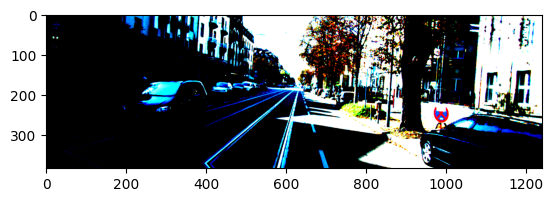

In [63]:
plt.imshow(dd)

In [15]:
d = Image.fromarray(d)

In [7]:
model = SegNet(n_channels=Num_Channel, n_classes=Num_Class)
#model = SegNet(in_chn=Num_Channel, out_chn=Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
model = UNet(n_channels=Num_Channel, n_classes=Num_Class, bilinear=True)
model = model.to(memory_format=torch.channels_last, device = device)

In [9]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#optimizer = optim.RMSprop(unet.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [10]:
# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

            with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                masks_pred = model(images)
                if model.n_classes == 1:
                    loss = criterion(masks_pred.squeeze(1), true_masks.float())
                    loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                else:
                    loss = criterion(masks_pred, true_masks)
                    loss += dice_loss(
                        F.softmax(masks_pred, dim=1).float(),
                        F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                        multiclass=True
                    )

            optimizer.zero_grad(set_to_none=True)
            grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
            grad_scaler.step(optimizer)
            grad_scaler.update()

            pbar.update(images.shape[0])
            global_step += 1
            epoch_loss += loss.item()


            # Evaluation round
            division_step = (n_train // (5 * batch_size))
            if division_step > 0:
                if global_step % division_step == 0:

                    val_score = evaluate(model, val_loader, device, amp)
                    
                    scheduler.step(val_score)

                    #logging.info('Validation Dice score: {}'.format(val_score))
                    print('Validation Dice score: {}'.format(val_score))
                    
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/1:  37%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 44/120 [00:03<00:04, 15.49img/s]

Validation Dice score: 0.6017255783081055



Epoch 1/1:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 64/120 [00:05<00:03, 14.23img/s]

Validation Dice score: 0.618442952632904



Epoch 1/1:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 88/120 [00:07<00:02, 15.01img/s]

Validation Dice score: 0.632627010345459



Epoch 1/1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 112/120 [00:09<00:00, 15.11img/s]

Validation Dice score: 0.6492306590080261



Epoch 1/1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:10<00:00, 11.01img/s]


Validation Dice score: 0.6485011577606201


In [15]:
masks_pred.shape

torch.Size([4, 31, 192, 608])